<a href="https://colab.research.google.com/github/Naveenand/Instruction-Finetuning-LLM/blob/main/content_title_prediction_using_bart_large_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall -y tensorflow --quiet
!pip install ludwig
!pip install ludwig[llm]

In [ ]:
!pip install datasets transformers

In [ ]:
import torch

In [ ]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))

get_ipython().events.register('pre_run_cell', set_css)

def clear_cache():
  if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [ ]:
from datasets import load_dataset
import pandas as pd
import numpy as np

In [ ]:
dataset = load_dataset('Naveengo/tldr_5000rows')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['headline', 'content', 'category'],
        num_rows: 5000
    })
})

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
data = pd.DataFrame(dataset['train'])

In [ ]:
data.head(5)

,headline,content,category
0,World's First Underground Hotel is Set to Open...,Shanghai's Intercontinental Shanghai Wonderlan...,2
1,How Loot Boxes Hooked gamers and Left Regulato...,Loot boxes have been around in games since the...,4
2,Herd Of Fuzzy Green 'Glacier Mice' Baffles Sci...,Glacier mice are balls of moss that can be fou...,4
3,Sponge Genes Hint at the Origins of Neurons an...,"A new study reveals how around 26,000 genes ar...",2
4,PocketBase (GitHub Repo),PocketBase is a Go backend consisting of an em...,3


In [ ]:
contents = data['content'][0]

In [ ]:
data['category'].head(5)

0    2
1    4
2    4
3    2
4    3
Name: category, dtype: int64

In [ ]:
data['category'].value_counts()

2    1335
1    1245
3    1223
4    1128
0      69
Name: category, dtype: int64

In [ ]:
dict = {
    1 : 'Big Tech & Startups',
    2 : 'Science and Futuristic Technology',
    3 : 'Programming, Design & Data Science',
    4 : 'Miscellaneous',
    0 : 'Sponsor'

}

In [ ]:
data['category'] = data['category'].map({
    1: 'Big Tech & Startups',
    2: 'Science and Futuristic Technology',
    3: 'Programming,Design & Data Science',
    4: 'Miscellaneous',
    0: 'Sponsor'
})

In [ ]:
data.head(5)

,headline,content,category
0,World's First Underground Hotel is Set to Open...,Shanghai's Intercontinental Shanghai Wonderlan...,Science and Futuristic Technology
1,How Loot Boxes Hooked gamers and Left Regulato...,Loot boxes have been around in games since the...,Miscellaneous
2,Herd Of Fuzzy Green 'Glacier Mice' Baffles Sci...,Glacier mice are balls of moss that can be fou...,Miscellaneous
3,Sponge Genes Hint at the Origins of Neurons an...,"A new study reveals how around 26,000 genes ar...",Science and Futuristic Technology
4,PocketBase (GitHub Repo),PocketBase is a Go backend consisting of an em...,"Programming,Design & Data Science"


Average number of tokens in the headline column: 20
Average number of tokens in the category column: 8
Average number of tokens in the content column: 161



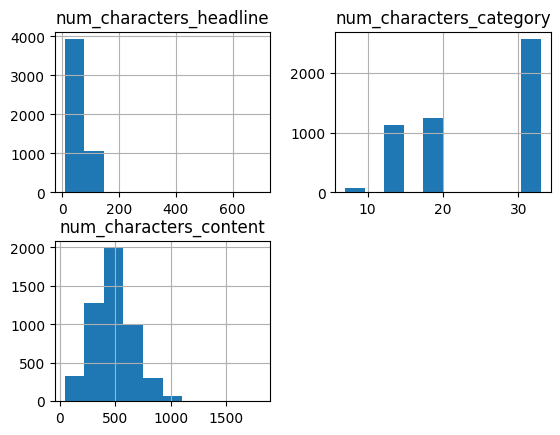

In [ ]:
# Calculating the length of each cell in each column
data['num_characters_headline'] = data['headline'].apply(lambda x: len(x))
data['num_characters_category'] = data['category'].apply(lambda x: len(x))
data['num_characters_content'] = data['content'].apply(lambda x: len(x))

# Show Distribution
data.hist(column=['num_characters_headline', 'num_characters_category','num_characters_content'])

# Calculating the average
average_chars_instruction = data['num_characters_headline'].mean()
average_chars_input = data['num_characters_category'].mean()
average_chars_output = data['num_characters_content'].mean()

print(f'Average number of tokens in the headline column: {(average_chars_instruction / 3):.0f}')
print(f'Average number of tokens in the category column: {(average_chars_input / 3):.0f}')
print(f'Average number of tokens in the content column: {(average_chars_output / 3):.0f}', end="\n\n")

In [ ]:
import getpass
import locale; locale.getpreferredencoding = lambda: "UTF-8"
import logging
import os
import torch
import yaml

from ludwig.api import LudwigModel

In [ ]:
qlora_fine_tuning_config = yaml.safe_load(
"""
model_type: llm
base_model: facebook/bart-large

input_features:
  - name: content
    type: text

output_features:
  - name: headline
    type: text

prompt:
  template: >-
    Below is a content that describes a news story, paired with an input that provides a news story category. Write a response title that appropriately completes the request.
    ### content: {content}

    ### category: {category}

    ### Response:

generation:
  temperature: 0.5
  max_new_tokens: 512

adapter:
  type: lora

quantization:
  bits: 4

preprocessing:
  global_max_sequence_length: 1024
  split:
    type: random
    probabilities:
    - 0.8
    - 0.1
    - 0.1

trainer:
  type: finetune
  epochs: 5
  batch_size: 3
  eval_batch_size: 2
  gradient_accumulation_steps: 16
  learning_rate: 0.0004
  learning_rate_scheduler:
    warmup_fraction: 0.03
"""
)

In [ ]:
model = LudwigModel(config=qlora_fine_tuning_config, logging_level=logging.INFO)

In [ ]:
results = model.train(dataset=data)

INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒════════════════════════╕
INFO:ludwig.utils.print_utils:│ EXPERIMENT DESCRIPTION │
INFO:ludwig.utils.print_utils:╘════════════════════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.api:╒══════════════════╤═════════════════════════════════════════════════════════════════════════════════════════╕
│ Experiment name  │ api_experiment                                                                          │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Model name       │ run                                                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Output directory │ /content/results/api_experiment_run                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────

INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of facebook/bart-large tokenizer
INFO:ludwig.features.text_feature:Max length of feature 'None': 448 (without start and stop symbols)
INFO:ludwig.features.text_feature:Setting max length using dataset: 450 (including start and stop symbols)
INFO:ludwig.features.text_feature:max sequence length is 450 for feature 'None'
INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of facebook/bart-large tokenizer
INFO:ludwig.features.text_feature:Max length of feature 'headline': 158 (without start and stop symbols)
INFO:ludwig.features.text_feature:Setting max length using dataset: 160 (including start and stop symbols)
INFO:ludwig.features.text_feature:max sequence length is 160 for feature 'headline'
INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of facebook/bart-large tokenizer
INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of facebook/bart-large tokenizer
INFO:ludwig.data.preprocessing:B

INFO:ludwig.models.llm:Done.
INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of facebook/bart-large tokenizer
INFO:ludwig.models.llm:==================================================
INFO:ludwig.models.llm:Trainable Parameter Summary For Fine-Tuning
INFO:ludwig.models.llm:Fine-tuning with adapter: lora
INFO:ludwig.models.llm:==================================================
INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒══════════╕
INFO:ludwig.utils.print_utils:│ TRAINING │
INFO:ludwig.utils.print_utils:╘══════════╛
INFO:ludwig.utils.print_utils:


trainable params: 786,432 || all params: 254,870,528 || trainable%: 0.30856137277669077


INFO:ludwig.trainers.trainer:Creating fresh model training run.
INFO:ludwig.trainers.trainer:Training for 6670 step(s), approximately 5 epoch(s).
INFO:ludwig.trainers.trainer:Early stopping policy: 5 round(s) of evaluation, or 6670 step(s), approximately 5 epoch(s).

INFO:ludwig.trainers.trainer:Starting with step 0, epoch: 0


Training:  20%|█▉        | 1333/6670 [03:18<11:33,  7.70it/s, loss=0.562]

INFO:ludwig.data.batcher.random_access:Last batch in epoch only has 1 sample and will be dropped.
INFO:ludwig.data.batcher.random_access:Last batch in epoch only has 1 sample and will be dropped.


Training:  20%|██        | 1334/6670 [03:19<30:57,  2.87it/s, loss=0.537]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 1334, epoch: 1


Evaluation test : 100%|██████████| 167/167 [00:15<00:00, 11.04it/s]

INFO:ludwig.trainers.trainer:Evaluation took 30.5032s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤════════════╤══════════════╤════════════╕
│                       │      train │   validation │       test │
╞═══════════════════════╪════════════╪══════════════╪════════════╡
│ bleu                  │     0.0000 │       0.0000 │     0.0000 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ char_error_rate       │     3.8060 │       1.0132 │     1.0040 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ loss                  │     8.5869 │       7.9288 │     7.9763 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ next_token_perplexity │ 49887.5547 │   49218.5820 │ 49249.3477 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ perplexity            │ 49777.8164 │   49306.2500 │ 49337.1055 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ rouge1_fmeasure       │     0.08


Training:  40%|███▉      | 2666/6670 [07:04<11:29,  5.81it/s, loss=0.51]

INFO:ludwig.data.batcher.random_access:Last batch in epoch only has 1 sample and will be dropped.
INFO:ludwig.data.batcher.random_access:Last batch in epoch only has 1 sample and will be dropped.


Training:  40%|████      | 2668/6670 [07:05<23:49,  2.80it/s, loss=0.512]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 2668, epoch: 2


Evaluation test : 100%|██████████| 167/167 [00:16<00:00, 10.06it/s]

INFO:ludwig.trainers.trainer:Evaluation took 33.8749s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤════════════╤══════════════╤════════════╕
│                       │      train │   validation │       test │
╞═══════════════════════╪════════════╪══════════════╪════════════╡
│ bleu                  │     0.0000 │       0.0000 │     0.0000 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ char_error_rate       │     3.3427 │       2.1706 │     1.9880 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ loss                  │     8.1971 │       7.5820 │     7.6308 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ next_token_perplexity │ 49240.0859 │   48282.4023 │ 48255.3438 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ perplexity            │ 50003.5352 │   48723.6367 │ 48731.7227 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ rouge1_fmeasure       │     0.06


Training:  60%|█████▉    | 3999/6670 [10:56<07:17,  6.11it/s, loss=0.42]

INFO:ludwig.data.batcher.random_access:Last batch in epoch only has 1 sample and will be dropped.
INFO:ludwig.data.batcher.random_access:Last batch in epoch only has 1 sample and will be dropped.


Training:  60%|██████    | 4002/6670 [10:57<12:43,  3.50it/s, loss=0.489]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 4002, epoch: 3


Evaluation test : 100%|██████████| 167/167 [00:24<00:00,  6.73it/s]

INFO:ludwig.trainers.trainer:Evaluation took 47.7318s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤════════════╤══════════════╤════════════╕
│                       │      train │   validation │       test │
╞═══════════════════════╪════════════╪══════════════╪════════════╡
│ bleu                  │     0.0000 │       0.0000 │     0.0000 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ char_error_rate       │     4.4528 │       7.6941 │     7.1587 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ loss                  │     7.8234 │       6.9315 │     7.0190 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ next_token_perplexity │ 45415.9883 │   44064.5078 │ 44194.2578 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ perplexity            │ 48452.6992 │   47750.9883 │ 47765.6992 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ rouge1_fmeasure       │     0.00


Training:  80%|███████▉  | 5332/6670 [15:19<03:55,  5.69it/s, loss=0.397]

INFO:ludwig.data.batcher.random_access:Last batch in epoch only has 1 sample and will be dropped.
INFO:ludwig.data.batcher.random_access:Last batch in epoch only has 1 sample and will be dropped.


Training:  80%|████████  | 5336/6670 [15:21<06:57,  3.20it/s, loss=0.419]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 5336, epoch: 4


Evaluation test : 100%|██████████| 167/167 [00:28<00:00,  5.89it/s]


INFO:ludwig.trainers.trainer:Evaluation took 55.2370s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤════════════╤══════════════╤════════════╕
│                       │      train │   validation │       test │
╞═══════════════════════╪════════════╪══════════════╪════════════╡
│ bleu                  │     0.0000 │       0.0000 │     0.0000 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ char_error_rate       │     8.6364 │       5.3605 │     5.3788 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ loss                  │     6.7039 │       5.8744 │     5.9898 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ next_token_perplexity │ 41529.7695 │   43654.0547 │ 43877.2148 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ perplexity            │ 48179.5547 │   49742.2266 │ 49755.2305 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ rouge1_fmeasure       │     0.03

Training: 100%|█████████▉| 6665/6670 [20:01<00:00,  6.51it/s, loss=0.425]

INFO:ludwig.data.batcher.random_access:Last batch in epoch only has 1 sample and will be dropped.
INFO:ludwig.data.batcher.random_access:Last batch in epoch only has 1 sample and will be dropped.


Training: 100%|██████████| 6670/6670 [20:03<00:00,  4.49it/s, loss=0.372]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 6670, epoch: 5


Evaluation test : 100%|██████████| 167/167 [00:30<00:00,  5.55it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1m 0.4108s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤════════════╤══════════════╤════════════╕
│                       │      train │   validation │       test │
╞═══════════════════════╪════════════╪══════════════╪════════════╡
│ bleu                  │     0.0000 │       0.0000 │     0.0000 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ char_error_rate       │     8.3883 │       6.5593 │     6.5414 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ loss                  │     5.9457 │       5.3136 │     5.4212 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ next_token_perplexity │ 41679.5508 │   42629.7891 │ 42874.1992 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ perplexity            │ 48771.0547 │   50005.3984 │ 49993.4297 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ rouge1_fmeasure       │     0.


Training: 100%|██████████| 6670/6670 [21:09<00:00,  5.25it/s, loss=0.372]

INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒═════════════════╕
INFO:ludwig.utils.print_utils:│ TRAINING REPORT │
INFO:ludwig.utils.print_utils:╘═════════════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.api:╒══════════════════════════════╤════════════════════╕
│ Validation feature           │ headline           │
├──────────────────────────────┼────────────────────┤
│ Validation metric            │ loss               │
├──────────────────────────────┼────────────────────┤
│ Best model step              │ 6670               │
├──────────────────────────────┼────────────────────┤
│ Best model epoch             │ 6                  │
├──────────────────────────────┼────────────────────┤
│ Best model's validation loss │ 5.313607692718506  │
├──────────────────────────────┼────────────────────┤
│ Best model's test loss       │ 5.4211626052856445 │
╘══════════════════════════════╧════════════════════╛
INFO:ludwig.api:
Finished: api_experiment_run
INFO:ludwig.api:Saved to

In [ ]:
!ludwig upload hf_hub --repo_id Naveengo/instruction-fine-tuned-on-tldr_news5000rows --model_path /content/results/api_experiment_run

adapter_model.bin: 100% 3.18M/3.18M [00:02<00:00, 1.14MB/s]
Model uploaded to `https://huggingface.co/Naveengo/instruction-fine-tuned-on-tldr_news5000rows/tree/main/` with repository name `Naveengo/instruction-fine-tuned-on-tldr_news5000rows`


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import shutil

# Source folder path
source_folder = '/content/results'

# Destination zip file path
zip_file = '/content/gdrive/MyDrive/title_prediction.zip'

# Create a zip file
shutil.make_archive(zip_file, 'zip', source_folder)

'/content/gdrive/MyDrive/title_prediction.zip.zip'

In [ ]:
content_length = "The much-awaited iOS 17 Journal app has finally arrived, and it is wonderful. Apple’s new Journal app lets iPhone users record their daily thoughts and activities. Unlike other journaling apps, the Journal app in iOS 17 incorporates data like photos, music listened to, workouts, and more. Moreover, while it’s known that the Journal app offers you personal suggestions, the steps to turn on journaling suggestions in the iOS 17 Journal app are still unknown to many. Well, we are here to help you with that."

In [ ]:
catgorys = 'Science and Futuristic Technology'

In [ ]:
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM

config = PeftConfig.from_pretrained("Naveengo/instruction-fine-tuned-on-tldr_news5000rows")
model = AutoModelForCausalLM.from_pretrained("facebook/bart-large")
model = PeftModel.from_pretrained(model, "Naveengo/instruction-fine-tuned-on-tldr_news5000rows")

In [ ]:
from transformers import AutoModelForCausalLM,  AutoTokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)

In [ ]:
tokenizer

In [ ]:
from IPython.display import display, Markdown

def make_inference(content,category):
  batch = tokenizer(f"Below is a content that describes a news story, paired with an input that provides a news story category. Write a response good length title that appropriately completes the request. ### content: {content} ### category: {category} ### Response:", return_tensors='pt')

  with torch.cuda.amp.autocast():
    output_tokens = model.generate(**batch, max_new_tokens=80)

  display(Markdown((tokenizer.decode(output_tokens[0], skip_special_tokens=True))))

In [ ]:
make_inference(contents,catgorys)

Below is a content that describes a news story, paired with an input that provides a news story category. Write a response good length title that appropriately completes the request. ### content: Shanghai's Intercontinental Shanghai Wonderland is a five star hotel that will be almost entirely underground. The top two floors will be covered in lush green grass, while the remaining 16 floors will extend underground into a mountain quarry. The hotel will have 383 rooms and cover 49,409 square meters. There will be a cascading waterfall at the top of the quarry, and the mountain itself will allow for the hotel to provide bungee jumping and rock climbing activities for the guests. ### category: Science and Futuristic Technology ### Response:sky mountain 